In [1]:
import ee
ee.Authenticate()

In [2]:
#Import required packages
ee.Initialize()
import pandas as pd
import numpy as np
import geopandas as gpd
import geemap
import json
import requests
from shapely.geometry import Point
from functools import reduce
import geemap.foliumap as foliumap
from matplotlib import pyplot as plt

In [3]:
# Set Up geometry, background and import yearly covariate rasters.
MY_state_abbrev = 'MN'
MY_state = 'Minnesota'
MY_scale = 1000
conus_states = ee.FeatureCollection('TIGER/2018/States')
MY_geo = conus_states.filter(ee.Filter.equals('STUSPS', MY_state_abbrev)).geometry() # Change to your state abbrev

background = ee.FeatureCollection("users/shopvac18/multistate_data/conus_background") # Change to the path where you stored the background csv
MY_background = background.filter(ee.Filter.bounds(MY_geo))

## Add yearly covariate rasters you made here. These are examples for MN
MN_2020 = ee.Image("users/shopvac18/cov_2020/Misota")
MN_2021 = ee.Image("users/shopvac18/cov_2021/Misota")

MY_collections = ee.ImageCollection([MN_2020, MN_2021]).mean()


In [4]:
#Helper functions for importing/formatting data from NAS API
def _get_col_rename(df, dftype):
    """Returns a dictionary of columns to rename based on the dataframe and type('csv' or 'api')"""
    
    # Build a dictionary of column renamings for use in pandas rename function
    renamed_columns = {}
    column_names = list(df.columns)
    lower_columns = [name.lower().replace(' ','').replace('_','') for name in column_names]
    for i in range(len(column_names)):
        renamed_columns[column_names[i]] = lower_columns[i]

    if dftype == 'csv':
        # build csv rename dictionary
        renamed_columns['museumcatno'] = 'museumcatnumber'
        renamed_columns['huc8number']  = 'huc8'
    elif dftype == 'api':
        # build api rename dictionary
        renamed_columns['key']              = 'specimennumber'
        renamed_columns['decimallatitude']  = 'latitude'
        renamed_columns['decimallongitude'] = 'longitude'
        renamed_columns['latlongsource']    = 'source'
        renamed_columns['latlongaccuracy']  = 'accuracy'
    else:
        raise ValueError(f"Dataframe type '{dftype}' invalid - Accepted inputs are 'csv' or 'api'")

    return renamed_columns

def _manage_cols(df, drop_list=[], name_dict={}):
    """Private method for dropping and renaming columns in a dataframe, as well as creating one standard table from two different forms."""

    for colname in drop_list:
        if colname not in df:
            raise ValueError(f"Can't drop column '{colname}' - '{colname}' does not exist in dataframe")
    for colname in list(name_dict.keys()):
        if colname not in df:
            raise ValueError(f"Can't rename '{colname}' to '{name_dict[colname]}' - '{colname}' does not exist in dataframe")
        if colname in drop_list:
            raise ValueError(f"Can't rename '{colname}' to '{name_dict[colname]}' - '{colname}' in drop_list")

    column_names = np.setdiff1d(list(df.columns), list(name_dict.keys()))
    lower_columns = [name.lower().replace(' ','').replace('_','') for name in column_names]
    for i in range(len(column_names)):
        name_dict[column_names[i]] = lower_columns[i]
    
    df = df.drop(drop_list, axis=1)
    df = df.rename(columns=name_dict)
    
    return df

URL_BASE = 'http://nas.er.usgs.gov/api/v2/'


def api_df(species_id, limit, api_key):
    """Returns a pandas dataframe containing records about a species from the NAS database using their API"""
    
    # Check for API key
    if api_key is not None:
        url_request = f"{URL_BASE}/occurrence/search?species_ID={species_id}&api_key={api_key}"
    else:
        url_request = f"{URL_BASE}/occurrence/search?species_ID={species_id}"
    
    # Get dataframe from API request
    request_json = requests.get(url_request, params={'limit':limit}).json()
    api_df = pd.json_normalize(request_json, 'results')
    api_df = _manage_cols(api_df)

    # Add columns that are in a CSV dataframe but not an API dataframe
    api_df['country']      = np.nan
    api_df['drainagename'] = np.nan

    # Rename columns
    renamed_columns = _get_col_rename(api_df, 'api')
    api_df = api_df.rename(columns=renamed_columns)

    # Reorder columns
    cols = list(api_df.columns)
    cols = cols[0:8] + cols[33:34] + cols[8:33] + cols[34:] # country
    cols = cols[0:16] + cols[34:] + cols[16:34] # drainagename
    api_df = api_df[cols]
    
    return api_df

# get species info from https://nas.er.usgs.gov/api/v2/species

ebt = api_df(species_id = 939, limit = 10000, api_key = 
             {"speciesID":939,"itis_tsn":162003,"group":"Fishes","family":"Salmonidae","genus":"Salvelinus",
              "species":"fontinalis","subspecies":"","variety":"","authority":"(Mitchill, 1814)",
              "common_name":"Brook Trout","native_exotic":"Native","Fresh/Marine/Brackish":"Freshwater"})

In [5]:
zm = api_df(species_id = 5, limit = 10000, api_key = {"speciesID":5,"itis_tsn":81339,"group":"Mollusks-Bivalves","family":"Dreissenidae","genus":"Dreissena","species":"polymorpha","subspecies":"","variety":"","authority":"(Pallas, 1771)","common_name":"zebra mussel","native_exotic":"Exotic","Fresh/Marine/Brackish":"Freshwater"})

In [ ]:
#You could also create a csv with your own points and read it in here or merge it with the points from the database
#local_data = pd.read_csv('your_local_file_path.csv')

In [6]:
my_data = zm[["state", "latitude", "longitude", "year", "status", "accuracy"]]

In [7]:
my_data_fltr = my_data[(my_data['status'] == 'established') & (my_data['accuracy'] == 'Accurate')
& (my_data['state'] == MY_state)] # Change to your state

In [8]:
my_data_fixed = my_data_fltr.dropna()

In [9]:
#turn it into a geo datafrome
user_data_gdf = gpd.GeoDataFrame(
    my_data_fixed, geometry=gpd.points_from_xy(my_data_fixed.longitude, my_data_fixed.latitude))

In [10]:
#add Coordinate Reference System (CRS)
user_data_gdf.crs = "EPSG:4326"

In [11]:
#convert geopandas object into ee object
fc = geemap.geopandas_to_ee(user_data_gdf)

In [12]:
#add present property 
def addPresent (property):
    return property.set('Present', 1);

user_data = fc.map(addPresent)

In [13]:
# split for training and testing
data_split = user_data.randomColumn()
training_data = data_split.filter(ee.Filter.lte('random', 0.75)).merge(MY_background)
testing_data = data_split.filter(ee.Filter.gt('random', 0.75))

In [14]:
covariate_choices = [
  'Heat_Insolation_Load', 
  'Topographic_Diversity', 
  'gHM', 
  'Max_LST_Annual',
  'Mean_GPP', 
  'Mean_NDVI', 
  'winter_totalPrecip', 
  'summer_totalPrecip', 
  'Flashiness',
  'elevation'
];

MY_input = MY_collections.select(covariate_choices);

In [15]:
training_points = MY_input.reduceRegions(**{
                              'collection': training_data,
                              'reducer': ee.Reducer.mean(),
                              'crs': 'EPSG:4326',
                              'scale': MY_scale,
                              'tileScale': 16})

In [16]:
#Define Classifier and setup for MaxEnt Parameters 
classifier = ee.Classifier.amnhMaxent().train(**{
    'features': training_points,
    'classProperty': 'Present',
    'inputProperties': MY_input.bandNames()
})

In [17]:
classifier_results = classifier.explain();
classifier_results

In [18]:
MY_input_classified = MY_input.classify(classifier);

In [19]:
#Create color paramaters and map classified image
Probability_PARAMS = {"opacity":1,"bands":["probability"],
"palette":["2b83ba","6ab0af","abdda4","cdebaf","ffffbf", "fed790", "fdae61", "d7191c","d7191c"]}
Map = foliumap.Map(center=[40,-100], zoom=4)
Map.addLayer(MY_input_classified, Probability_PARAMS, 'Habitat Suitability')
Map

In [20]:
testing_points = MY_input_classified.reduceRegions(**{
                              'collection': testing_data,
                              'reducer': ee.Reducer.mean(),
                              'crs': 'EPSG:4326',
                              'scale': MY_scale,
                              'tileScale': 16})

In [21]:
false_neg_testing = testing_points.select('probability');

In [22]:
my_false_negs =  false_neg_testing.filter(ee.Filter.lessThan('probability', 0.30)).size();

In [23]:
my_true_pos = false_neg_testing.filter(ee.Filter.greaterThan('probability', 0.70)).size();

In [24]:
my_fn_rate =  my_false_negs.divide(my_false_negs.add(my_true_pos));

In [25]:
my_fn_rate

In [26]:
false_neg_df = geemap.ee_to_df(false_neg_testing)

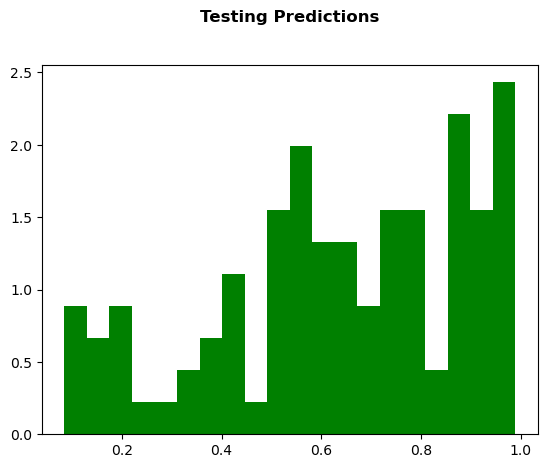

In [27]:
n_bins = 20
x = false_neg_df
plt.hist(x, n_bins, density = True, 
         histtype ='bar',
         color = 'green')

plt.title('Testing Predictions\n\n',
          fontweight ="bold")
  
plt.show()

In [ ]:
#Export Map as GeoTiff
export = ee.batch.Export.image.toDrive(image = MY_input_classified,
                    description = 'MY_prediction',
                    region = MY_geo,
                    scale =  MY_scale,
                    maxPixels = 1e13)
export.start()